<a href="https://colab.research.google.com/github/szymonkulpinski/colab_notebooks/blob/main/teams_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check if GPU is in use
If this command fails: click in the upper-right corner of this window 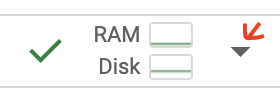
 and select `Change runtime type` and then select `T4 GPU`







In [ ]:
!nvidia-smi

Mon Feb  3 01:42:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install all dependencies

In [ ]:
!pip install -q roboflow supervision umap-learn tqdm transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.5 MB/s eta 0:00:00


### Make all the relevant imports

In [ ]:
import os
import time
import pickle
import umap
import torch
import cv2
import warnings

import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

from tqdm import tqdm
from roboflow import Roboflow
from google.colab import userdata
from pathlib import Path
from sklearn.cluster import KMeans
from more_itertools import chunked
from typing import Tuple
from transformers import AutoFeatureExtractor, ResNetModel, AutoProcessor, SiglipVisionModel,CLIPProcessor, CLIPVisionModel

### Define constants and settings


In [45]:
if 'google.colab' in str(get_ipython()):
  HOME = "/content"
else:
  HOME = os.getcwd()

# In the used dataset all of the images have the resolution of 1920x1080px
IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1080

# Settings
NUM_ITERATIONS = 2 # set to 1 if you only want to evaluate once, for evalutation used 50
BATCH_SIZE_ARRAY = [32]
FOLDER_DIR = "/content/drive/MyDrive/0_teams-clustering" # where in google colab the experiments results should be saved
RUN_EXPERIMENTS = True # if set to true experiments will be run, if to false it will only read saved results

versions_to_test = [
  "google/siglip-base-patch16-512",
  "google/siglip-base-patch16-384",
  "google/siglip-base-patch16-256",
  "google/siglip-base-patch16-224",
  "google/siglip-large-patch16-256",
  "google/siglip-large-patch16-384",
  "google/siglip-so400m-patch14-384",
  "google/siglip-so400m-patch14-224",
  "google/siglip-so400m-patch16-256-i18n",
  "microsoft/resnet-18",
  "microsoft/resnet-26",
  "microsoft/resnet-34",
  "microsoft/resnet-50",
  "microsoft/resnet-101",
  "microsoft/resnet-152",
  'openai/clip-vit-base-patch16',
  'openai/clip-vit-base-patch32',
  'openai/clip-vit-large-patch14',
  'openai/clip-vit-large-patch14-336',
]

# Ablation study settings
DO_ABLATION_STUDY = False
# BATCH_SIZE_ARRAY = [1,2,8,32] # values used in the ablation study


### Mount your google drive to google colab be able to save the results

In [19]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
Path(FOLDER_DIR).mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get the dataset and adjust the folder structure
If you haven't added your `ROBOFLOW_API_KEY` to your secrets in Google Colab, this code snippet will fail. Follow the instructions in this [Roboflow Notebook](https://colab.research.google.com/github/roboflow/sports/blob/main/examples/soccer/notebooks/train_player_detector.ipynb#scrollTo=BSd93ZJzZZKt) to add it.


In [18]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key=userdata.get('ROBOFLOW_API_KEY'))
project = rf.workspace("szymon-kulpinski").project("football-players-clustering")
version = project.version(6)
dataset = version.download("yolov8") # use the format as the easier to work with then e.g. COCO
print(dataset.location)

!mv {dataset.location}/train/images/* {dataset.location}/train/
!mv {dataset.location}/train/labels/* {dataset.location}/train/
!rm -rdf {dataset.location}/train/images
!rm -rdf {dataset.location}/train/labels

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...
/content/datasets/football-players-clustering-6
mv: cannot stat '/content/datasets/football-players-clustering-6/train/images/*': No such file or directory
mv: cannot stat '/content/datasets/football-players-clustering-6/train/labels/*': No such file or directory


### Load the dataset as Supervision Detections

In [ ]:
def convert_yolov8bbox_2_xyxy(xcycwh: np.ndarray) -> np.ndarray:
  # center_x center_y width height from https://roboflow.com/formats/yolov8-pytorch-txt.
  xcycwh[:,0] = xcycwh[:,0] * IMAGE_WIDTH
  xcycwh[:,1] = xcycwh[:,1] * IMAGE_HEIGHT
  xcycwh[:,2] = xcycwh[:,2] * IMAGE_WIDTH
  xcycwh[:,3] = xcycwh[:,3] * IMAGE_HEIGHT
  return sv.xcycwh_to_xyxy(xcycwh)

In [ ]:
folder_path = Path(dataset.location)/ "train"
jpg_files = list(folder_path.glob('**/*.jpg'))
txt_files = [file.with_suffix('.txt') for file in jpg_files]

detections_list = []
for file in txt_files:
  data = np.loadtxt(str(file))
  class_id = data[:,0].astype(np.int32)
  xyxy = convert_yolov8bbox_2_xyxy(data[:,1:])
  detections_list.append(sv.Detections(xyxy=xyxy, class_id=class_id))
print(detections_list[0])

Detections(xyxy=array([[1303.   ,  298.   , 1321.   ,  341.   ],
       [1272.435,  314.005, 1303.005,  359.635],
       [1343.   ,  320.   , 1369.   ,  367.   ],
       [1464.   ,  353.   , 1492.   ,  407.   ],
       [1193.13 ,  333.   , 1213.13 ,  386.   ],
       [1108.   ,  291.   , 1133.   ,  338.   ],
       [1372.   ,  345.   , 1396.   ,  398.   ],
       [ 649.   ,  354.   ,  668.   ,  410.   ],
       [1256.   ,  364.13 , 1286.   ,  419.13 ],
       [ 880.   ,  297.   ,  895.   ,  342.   ],
       [ 937.   ,  341.   ,  954.   ,  393.   ],
       [1489.   ,  373.   , 1520.   ,  423.   ],
       [1147.   ,  428.   , 1176.   ,  493.   ],
       [ 447.   ,  393.   ,  479.   ,  457.   ],
       [ 796.   ,  775.   ,  843.   ,  886.   ],
       [ 476.   ,  440.   ,  503.   ,  507.   ],
       [ 538.   ,  468.   ,  579.   ,  536.   ],
       [ 724.   ,  782.   ,  768.   ,  897.   ],
       [1167.   ,  543.   , 1217.   ,  622.   ],
       [1453.   ,  473.13 , 1487.   ,  541.13 ],
    

### Visualise the detections on the image, double check if the conversion was successful


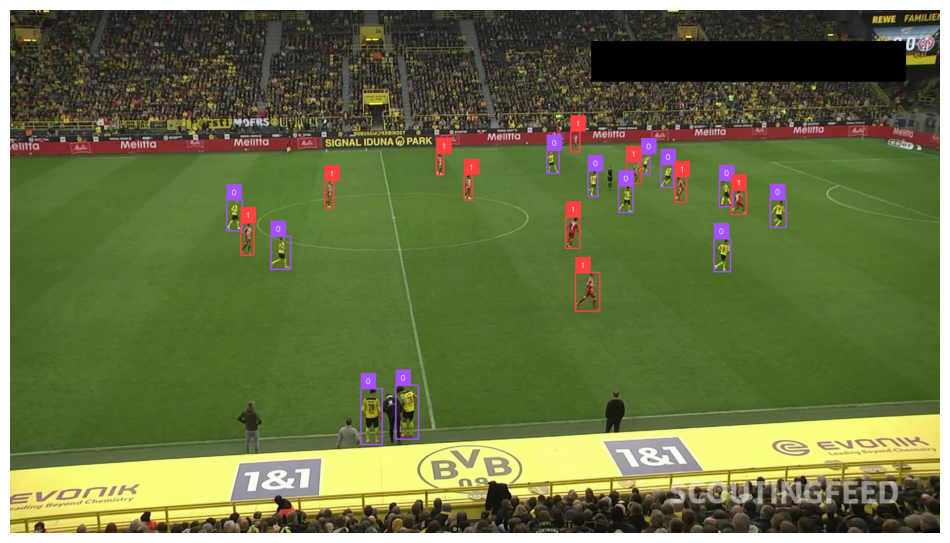

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
image= cv2.imread(str(jpg_files[0]))
detections = detections_list[0]
annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)
sv.plot_image(image=annotated_image, size=(12, 12))

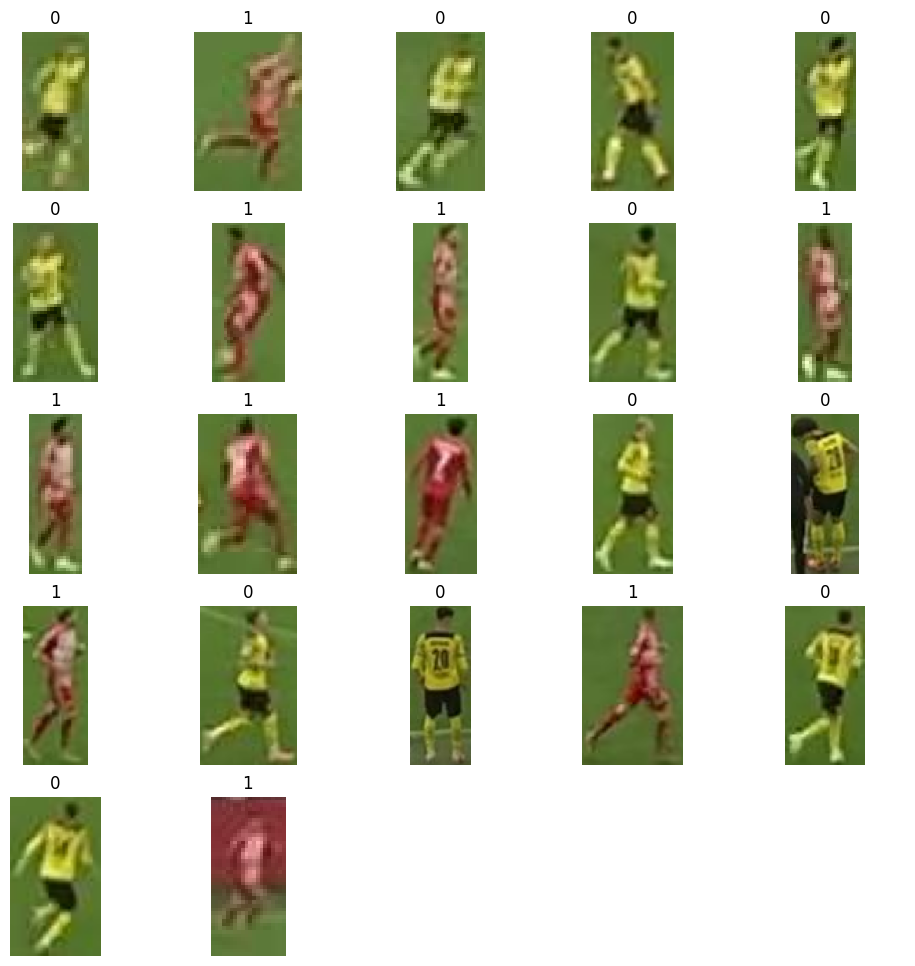

In [ ]:
players_crops = [sv.crop_image(image, xyxy) for xyxy in detections.xyxy]
sv.plot_images_grid(players_crops, grid_size=(5,5), titles = [f"{i}" for i in detections_list[0].class_id])

### Define helper methods and class

In [ ]:
class Experiment:
  def __init__(self, model_path: str):
    self.model_path = model_path
    self.model = None
    self.processor = None
    self.results_list = []
    self.clusters_list = []
    self.execution_time_list = []
    self.total_execution_time_list = []
    if "clip" in model_path:
      self.model_type = "CLIP"
    elif "siglip" in model_path:
      self.model_type = "SIGLIP"
    elif "resnet" in model_path:
      self.model_type = "RESNET"
    else:
      raise ValueError("Unknown model type")


  def init_model_n_processor(self):
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    if self.model_type == "CLIP":
      self.model = CLIPVisionModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoProcessor.from_pretrained(self.model_path)
    elif self.model_type == "SIGLIP":
      self.model = SiglipVisionModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoProcessor.from_pretrained(self.model_path)
    elif self.model_type == "RESNET":
      self.model = ResNetModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoFeatureExtractor.from_pretrained(self.model_path)


  def forward(self, batch: np.ndarray) -> np.ndarray:
    with torch.no_grad():
      inputs = self.processor(images=batch, return_tensors="pt").to(DEVICE)
      outputs = self.model(**inputs)
      if self.model_type == "RESNET":
        embeddings = torch.mean(outputs.last_hidden_state, dim=[2, 3]).cpu().numpy()
      else:
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
      return embeddings


  def clean_up(self):
    self.model = None
    self.processor = None


In [ ]:
def get_best_results_n_clusters(b_clusters: np.ndarray, b_class_id: np.ndarray)-> Tuple[np.ndarray, np.ndarray]:
  '''
    Compares predicted clusters (b_clusters) with ground truth class IDs (b_class_id)
    and potentially inverts the clusters to achieve the best possible accuracy.

    Setting all predictions to 1 or 0 will have at least a 50% success rate,
    so the classifier cannot perform worse than that.
    The assignment of cluster 0 and cluster 1 is arbitrary.
    Inverting the results to the "best result" corresponds to actual classification results.

    Args:
        b_clusters (np.ndarray): Predicted cluster assignments (0 or 1).
        b_class_id (np.ndarray): Ground truth class IDs (0 or 1).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - A boolean array indicating whether each prediction is correct after potential inversion.
            - The cluster assignments (0 or 1) after potential inversion.
  '''

  result = b_clusters == b_class_id
  if result.sum() < len(clusters)/2:
    b_clusters = ~b_clusters
    result = b_clusters == b_class_id
  return result, b_clusters.astype(np.int32)

def save_results_to_google_drive(experiments_list: list, batch_size: int, is_iteration=False):
  if is_iteration:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch32_it" + str(batch_size) + ".pkl"))
  else:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch" + str(batch_size) + ".pkl"))
  with open(filename, 'wb') as f:
    pickle.dump(experiments_list, f)

def load_results_from_google_drive(batch_size: list, is_iteration=False):
  if is_iteration:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch32_it" + str(batch_size) + ".pkl"))
  else:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch" + str(batch_size) + ".pkl"))
  loaded_experiment_list = None
  with open(filename, 'rb') as f:
    loaded_experiment_list = pickle.load(f)
  return loaded_experiment_list


### Init methods

In [24]:
Umap_reducer = umap.UMAP(n_components=3)
KMeans_model = KMeans(n_clusters=2)

experiments_list = [Experiment(model_path) for model_path in versions_to_test]
print(len(experiments_list))

2


### Run the evaluation and save the results to your google drive for future evaluation

In [ ]:
if RUN_EXPERIMENTS:
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
  warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

  for iteration in range(NUM_ITERATIONS):
    print("Iteration: ", iteration)
    experiments_list = [Experiment(model_path) for model_path in versions_to_test] # prevent appending into infinity, create objects anew
    for batch_size in BATCH_SIZE_ARRAY:
      for k, exp in enumerate(experiments_list):
        print("Model:", exp.model_path)
        print("Batch size:", batch_size)
        exp.init_model_n_processor()
        for i, image_path in tqdm(enumerate(jpg_files), desc='per image', total=len(jpg_files)):
            image = cv2.imread(str(image_path))
            players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[i].xyxy]
            pillow_crops = [sv.cv2_to_pillow(crop) for crop in players_crops]
            batches = chunked(pillow_crops, batch_size)

            data = []
            start_time = time.perf_counter()
            for batch in batches:
              data.append(exp.forward(batch))
            end_time = time.perf_counter()
            exp.execution_time_list.append(end_time - start_time)

            data = np.concatenate(data)
            projections = Umap_reducer.fit_transform(data)
            clusters = np.array(KMeans_model.fit_predict(projections))

            total_time = time.perf_counter()
            exp.total_execution_time_list.append(total_time - start_time)

            result, clusters = get_best_results_n_clusters(clusters.astype(bool), detections_list[i].class_id.astype(bool))
            exp.results_list.append(result.sum() / len(clusters))
            exp.clusters_list.append(clusters)
        exp.clean_up()
        experiments_list[k] = exp

        print("Mean accuracy: ", np.mean(exp.results_list))
        print("Mean execution time: ", np.mean(exp.execution_time_list))
        print("Mean FPS: ", 1/np.mean(exp.execution_time_list))
        print("Double check exp.results_list length: ", len(exp.results_list))
        print(exp.results_list)
        print("\n")

      save_results_to_google_drive(experiments_list, iteration, is_iteration=True)

Iteration:  0
Model: google/siglip-base-patch16-512
Batch size: 32


config.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/815M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


Mean accuracy:  0.7495927698032961
Mean execution time:  1.5677997833999688
Mean FPS:  0.6378365468525423
Double check exp.results_list length:  50
[0.6363636363636364, 0.85, 0.8, 1.0, 0.8, 0.8, 0.55, 0.8, 0.65, 1.0, 0.9, 0.8, 1.0, 0.5263157894736842, 0.7, 0.55, 0.55, 0.6, 1.0, 0.5, 0.7, 0.7222222222222222, 0.65, 0.5, 0.9, 0.85, 1.0, 0.9, 0.6, 0.631578947368421, 0.65, 0.85, 0.5263157894736842, 0.55, 0.5, 0.7, 0.75, 0.65, 0.7, 0.7, 0.6, 0.95, 0.9, 1.0, 0.55, 1.0, 0.7368421052631579, 1.0, 1.0, 0.7]


Model: google/siglip-base-patch16-384
Batch size: 32


config.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/814M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Mean accuracy:  0.7374311536416799
Mean execution time:  0.8249165644800268
Mean FPS:  1.2122438111426872
Double check exp.results_list length:  50
[0.7727272727272727, 0.9, 0.95, 1.0, 0.85, 0.6, 0.8, 0.75, 0.65, 0.95, 0.9, 0.75, 1.0, 0.5263157894736842, 0.7, 0.6, 0.6, 0.65, 0.95, 0.55, 0.65, 0.7777777777777778, 0.7, 0.5, 0.75, 0.95, 0.65, 0.95, 0.65, 0.631578947368421, 1.0, 0.65, 0.5263157894736842, 0.5, 0.55, 0.65, 0.7, 0.65, 0.85, 0.75, 0.55, 0.55, 0.95, 1.0, 0.55, 0.5, 0.7368421052631579, 0.95, 0.95, 0.65]


Model: google/siglip-base-patch16-256
Batch size: 32


config.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Mean accuracy:  0.7351685273790537
Mean execution time:  0.3185020848999375
Mean FPS:  3.1396968729864545
Double check exp.results_list length:  50
[0.6818181818181818, 0.85, 0.85, 1.0, 0.85, 0.85, 0.6, 0.55, 0.7, 1.0, 0.85, 0.9, 0.95, 0.5263157894736842, 0.65, 0.7, 0.55, 0.6, 0.9, 0.55, 0.75, 0.5555555555555556, 0.95, 0.6, 0.9, 0.75, 0.55, 1.0, 0.6, 0.631578947368421, 0.6, 0.95, 0.5263157894736842, 0.5, 0.55, 0.65, 0.65, 0.75, 0.55, 0.75, 0.6, 0.75, 0.95, 0.95, 0.5, 0.75, 0.7368421052631579, 0.9, 1.0, 0.75]


Model: google/siglip-base-patch16-224
Batch size: 32


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Mean accuracy:  0.7303200425305688
Mean execution time:  0.2664220596600535
Mean FPS:  3.7534429441614923
Double check exp.results_list length:  50
[0.7727272727272727, 0.95, 0.85, 1.0, 0.85, 0.5, 0.7, 0.7, 0.7, 0.75, 0.85, 0.85, 1.0, 0.5263157894736842, 0.55, 0.6, 0.65, 0.55, 0.85, 0.6, 0.7, 0.7222222222222222, 0.7, 0.65, 0.55, 1.0, 1.0, 0.95, 0.6, 0.631578947368421, 0.6, 0.65, 0.5263157894736842, 0.55, 0.5, 0.65, 0.65, 0.7, 0.75, 0.75, 0.6, 0.95, 0.95, 1.0, 0.6, 0.55, 0.7368421052631579, 0.9, 0.95, 0.65]


Model: google/siglip-large-patch16-256
Batch size: 32


config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


Mean accuracy:  0.6901105794790005
Mean execution time:  0.9658703763799895
Mean FPS:  1.0353356148554071
Double check exp.results_list length:  50
[0.5909090909090909, 0.9, 0.7, 0.65, 0.85, 0.9, 0.55, 1.0, 0.7, 0.65, 0.95, 0.6, 0.65, 0.5789473684210527, 0.6, 0.65, 0.55, 0.5, 0.95, 0.55, 0.75, 0.7777777777777778, 0.55, 0.5, 0.5, 1.0, 0.8, 0.75, 0.55, 0.631578947368421, 0.65, 0.75, 0.7894736842105263, 0.6, 0.55, 0.7, 0.6, 0.55, 0.7, 0.7, 0.55, 0.55, 0.6, 0.6, 0.5, 0.75, 0.7368421052631579, 1.0, 0.85, 0.9]


Model: google/siglip-large-patch16-384
Batch size: 32


config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


Mean accuracy:  0.6812099946836789
Mean execution time:  2.2757269909400746
Mean FPS:  0.43942002005561853
Double check exp.results_list length:  50
[0.5909090909090909, 0.9, 0.6, 0.8, 0.75, 0.6, 0.7, 0.7, 0.8, 0.55, 0.9, 0.65, 0.65, 0.9473684210526315, 0.6, 0.65, 0.55, 0.55, 1.0, 0.55, 0.65, 0.7222222222222222, 0.6, 0.6, 0.55, 0.9, 1.0, 0.6, 0.5, 0.631578947368421, 0.8, 0.7, 0.631578947368421, 0.55, 0.55, 0.65, 0.6, 0.5, 0.7, 0.65, 0.55, 0.65, 0.65, 0.8, 0.55, 0.55, 0.7368421052631579, 0.7, 0.85, 0.9]


Model: google/siglip-so400m-patch14-384
Batch size: 32


config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [03:31<00:00,  4.24s/it]


Mean accuracy:  0.673970760233918
Mean execution time:  4.183821790580078
Mean FPS:  0.23901591656019178
Double check exp.results_list length:  50
[0.5, 0.75, 0.85, 0.8, 0.8, 0.55, 0.65, 0.5, 0.5, 0.8, 0.8, 0.55, 0.65, 0.5263157894736842, 0.65, 0.55, 0.65, 0.55, 0.85, 0.55, 0.7, 0.7222222222222222, 0.65, 0.6, 0.55, 0.75, 0.8, 0.8, 0.6, 0.5789473684210527, 0.85, 0.65, 0.6842105263157895, 0.6, 0.55, 0.75, 0.5, 0.75, 0.6, 0.75, 0.55, 0.8, 0.85, 0.75, 0.55, 0.55, 0.7368421052631579, 0.9, 0.75, 0.8]


Model: google/siglip-so400m-patch14-224
Batch size: 32


config.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

#### Visualise one of the results for some or all of the images for the last experiment


In [ ]:
def display_for_id(id: int, exp: Experiment):
  image = cv2.imread(str(jpg_files[id]))
  players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[id].xyxy]
  print("Score: ", exp.results_list[id])
  sv.plot_images_grid(players_crops, grid_size=(5,5),
                      titles = [f"gt:{i} pred:{j}" for i,j in zip(detections_list[id].class_id,exp.clusters_list[id])])

# display_for_id(np.argmax(exp.results_list), exp)
display_for_id(np.argmin(exp.results_list), exp)
# for id in range(len(exp.results_list)):
#   display_for_id(id, exp)

NameError: name 'exp' is not defined

# Individual cumulativ evaluation plots


In [44]:
all_experiments_for_all_iterations=[]
# NUM_ITERATIONS = 50
NUM_ITERATIONS_ARRAY = range(NUM_ITERATIONS)
for it in NUM_ITERATIONS_ARRAY:
  all_experiments_for_all_iterations.append(load_results_from_google_drive(it, is_iteration=True))

# Settings
num_images = len(all_experiments_for_all_iterations[0][0].results_list)
rows = NUM_ITERATIONS * num_images

accuracy_array = np.zeros((rows, len(versions_to_test)))
exec_time_array = np.zeros((rows, len(versions_to_test)))
total_exec_time_array = np.zeros((rows, len(versions_to_test)))
model_name_list = []

for i_exp in range(len(all_experiments_for_all_iterations[0])): # for experiment, every batch has the same amount of methods in it
  for i_batch in range(len(all_experiments_for_all_iterations)): # for iteration
    current_exp = all_experiments_for_all_iterations[i_batch][i_exp]
    accuracy_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.results_list
    exec_time_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.execution_time_list
    total_exec_time_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.total_execution_time_list
  model_name_list.append(current_exp.model_path)


ValueError: could not broadcast input array from shape (100,) into shape (50,)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


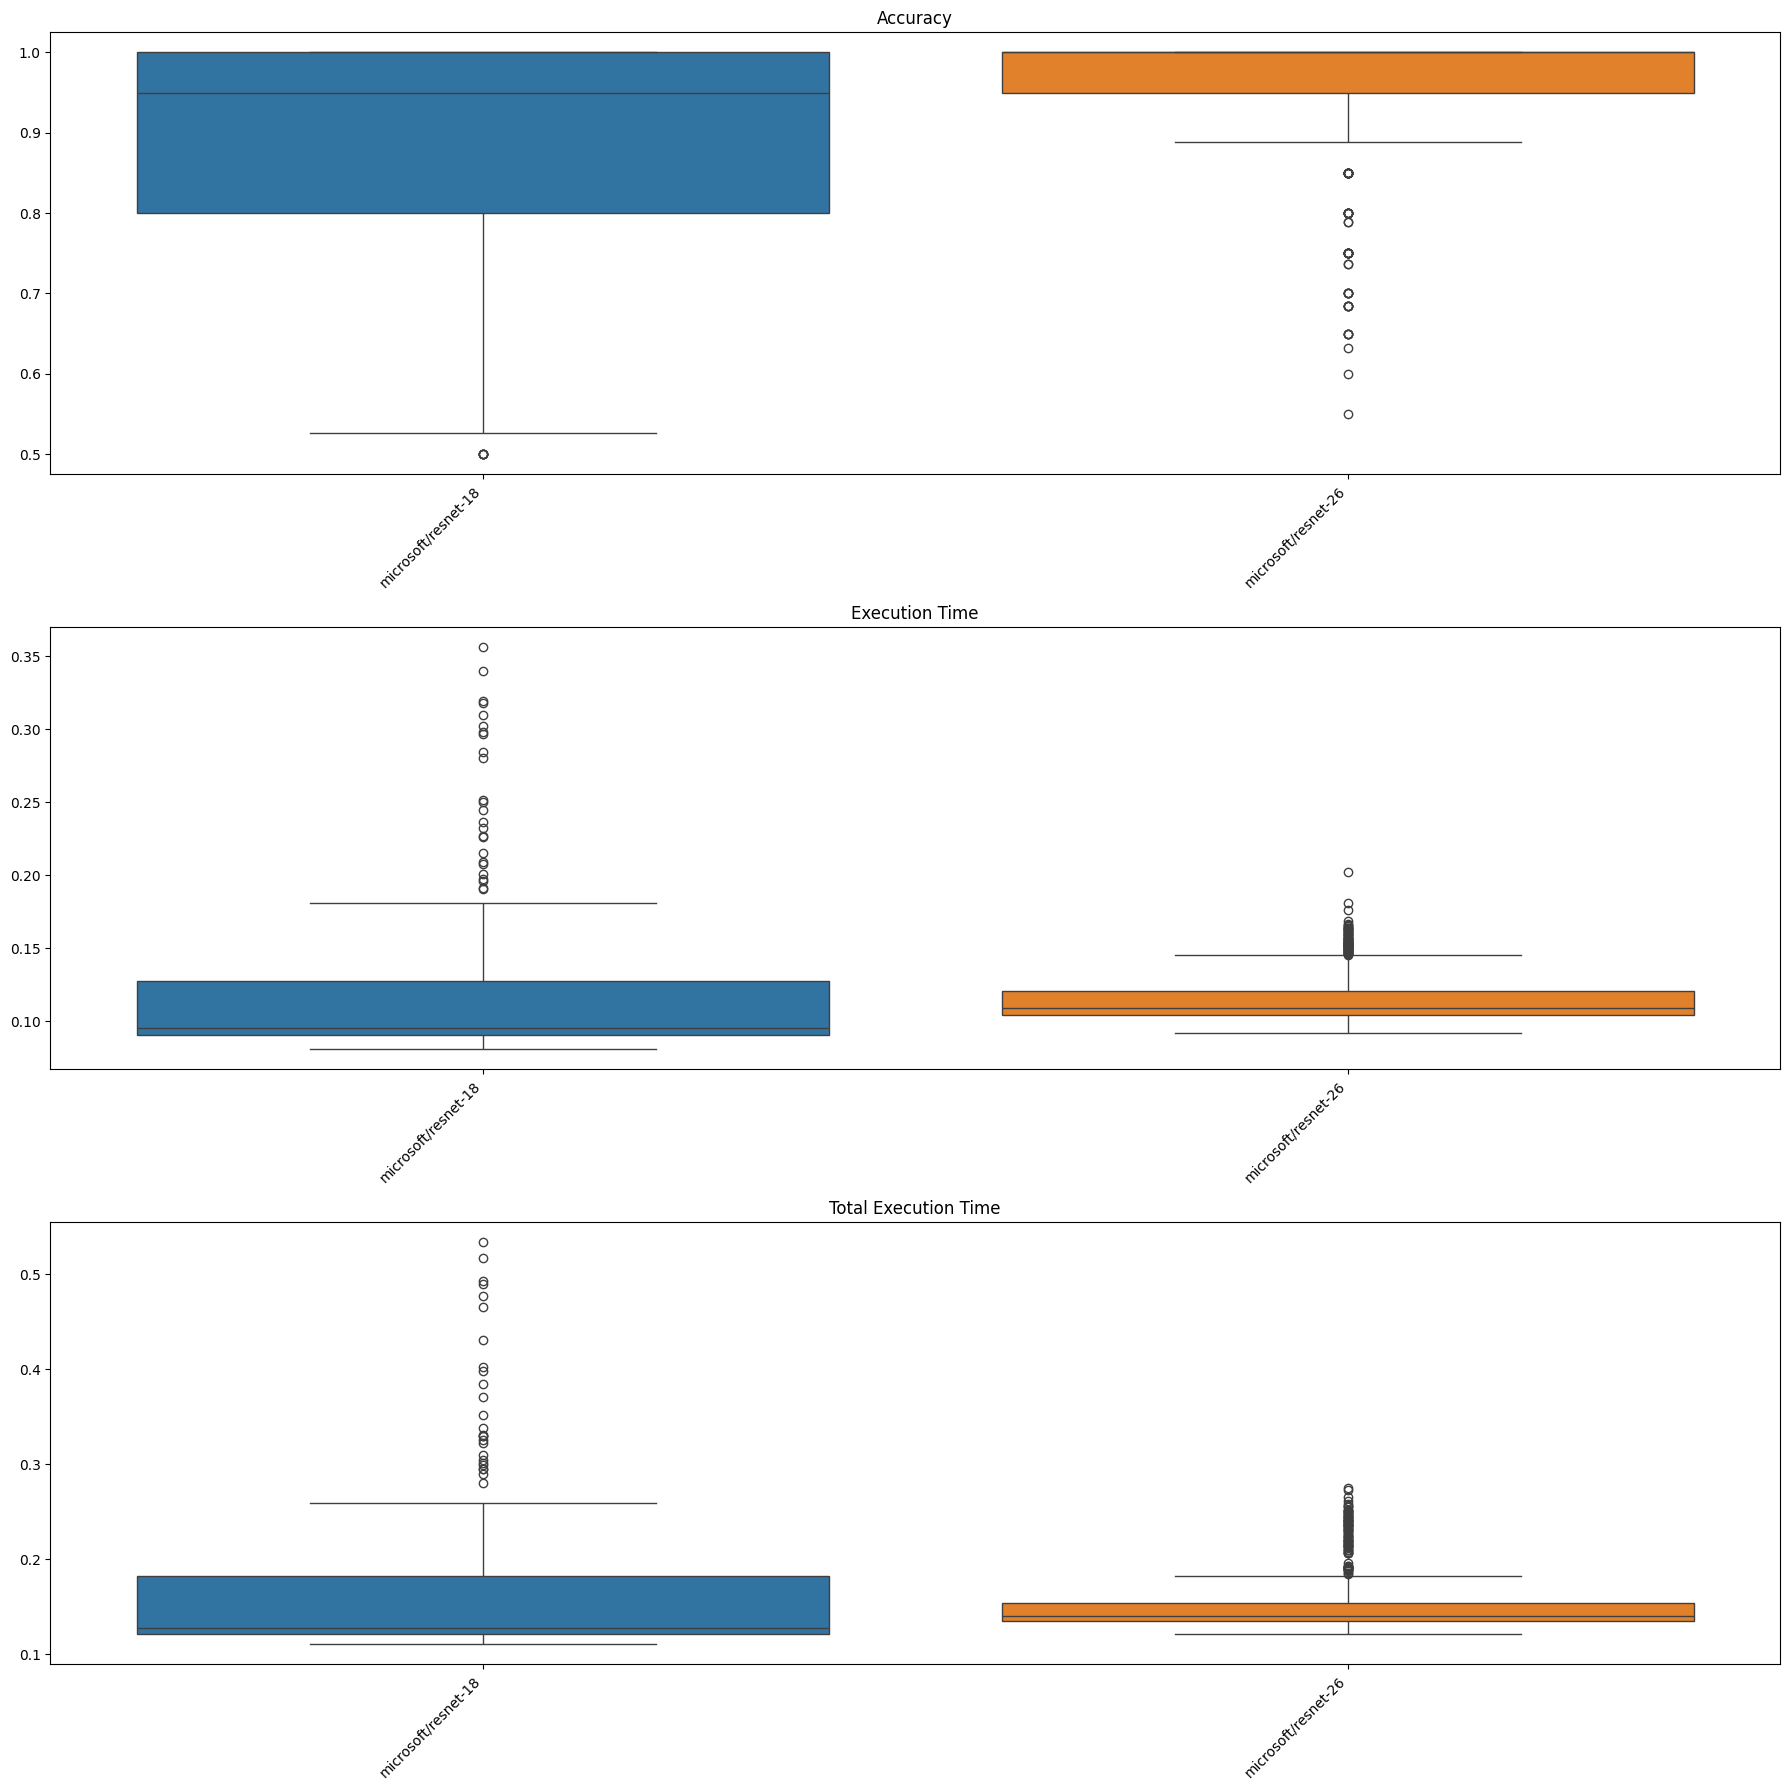

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axes for the boxplots
fig, axes = plt.subplots(3, 1, figsize=(18, 18))  # 3 rows, 1 column

# Boxplot for accuracy_array
sns.boxplot(data=accuracy_array, ax=axes[0])
axes[0].set_title('Accuracy')
axes[0].set_xticklabels(model_name_list, rotation=45, ha='right')

# Boxplot for exec_time_array
sns.boxplot(data=exec_time_array, ax=axes[1])
axes[1].set_title('Execution Time')
axes[1].set_xticklabels(model_name_list, rotation=45, ha='right')

# Boxplot for total_exec_time_array
sns.boxplot(data=total_exec_time_array, ax=axes[2])
axes[2].set_title('Total Execution Time')
axes[2].set_xticklabels(model_name_list, rotation=45, ha='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Evaluation

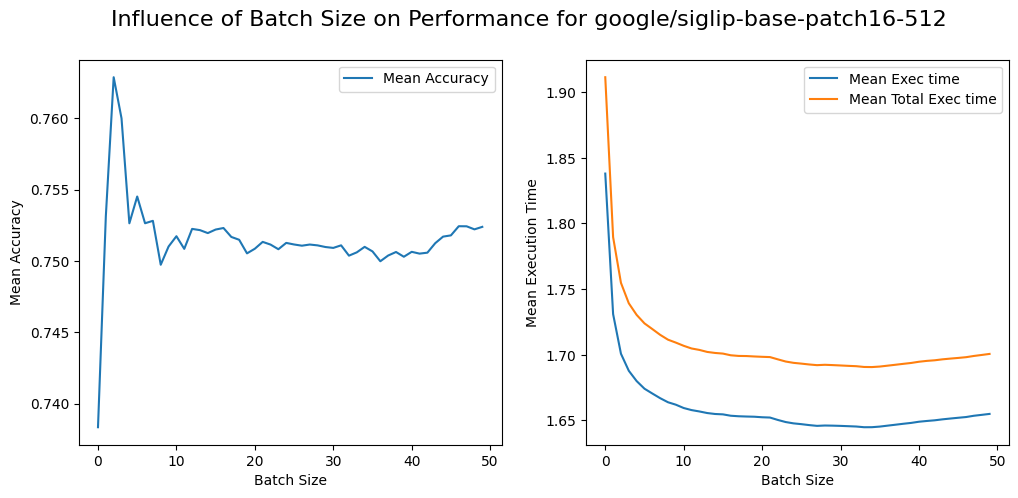

google/siglip-base-patch16-512
Accuracy difference:  3.21678302185266
Execution time difference:  10.511312783562985
Total execution time difference:  11.550350357276695


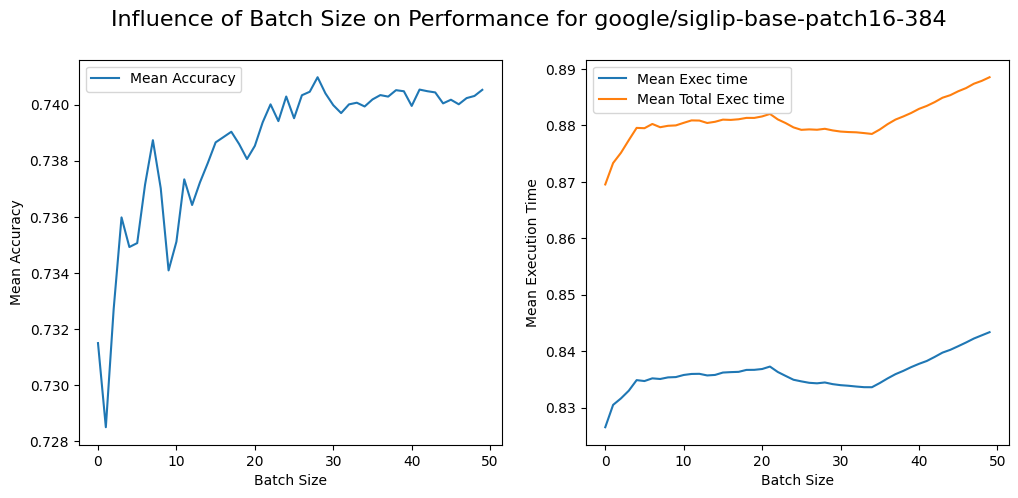

google/siglip-base-patch16-384
Accuracy difference:  1.6863244552690744
Execution time difference:  1.9959049372148034
Total execution time difference:  2.136997456707433


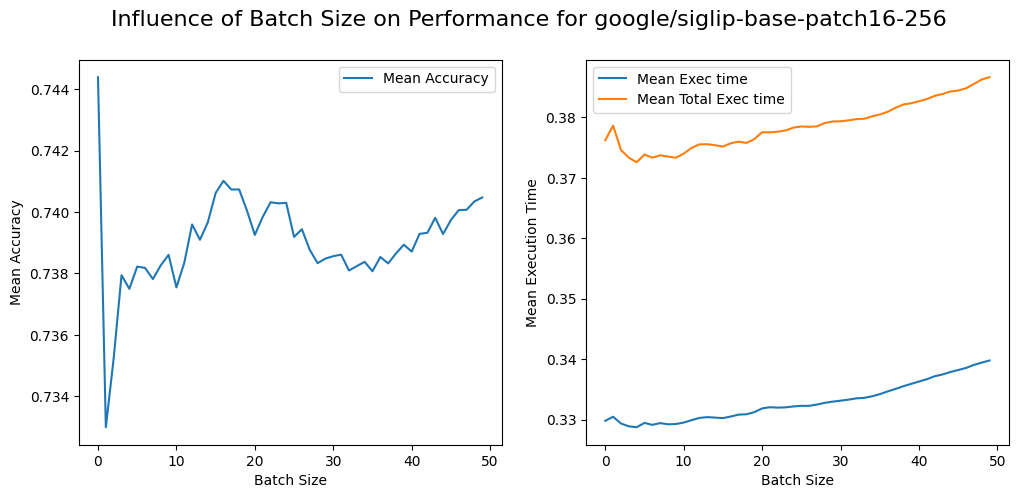

google/siglip-base-patch16-256
Accuracy difference:  1.5313180483631121
Execution time difference:  3.2513370006458437
Total execution time difference:  3.6399464094883447


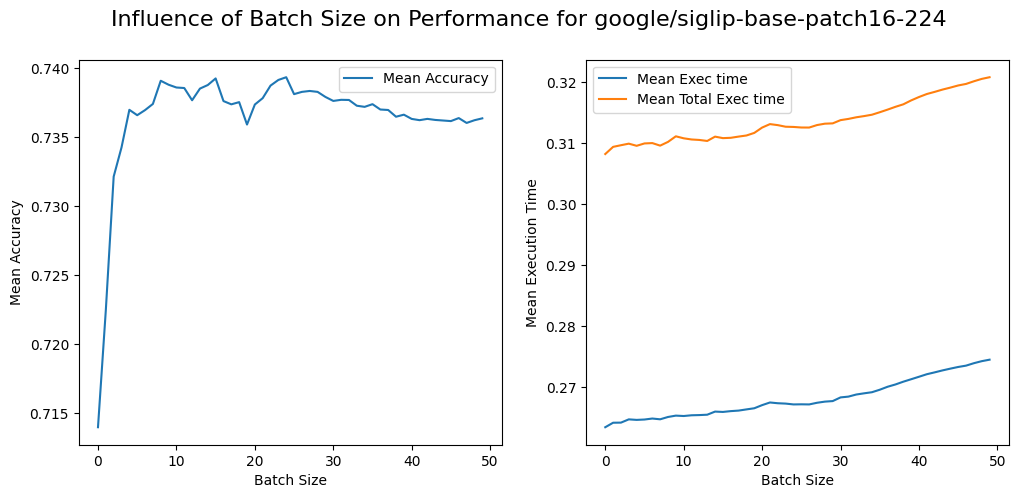

google/siglip-base-patch16-224
Accuracy difference:  3.431252284773919
Execution time difference:  4.035119542243462
Total execution time difference:  3.9263064022915453


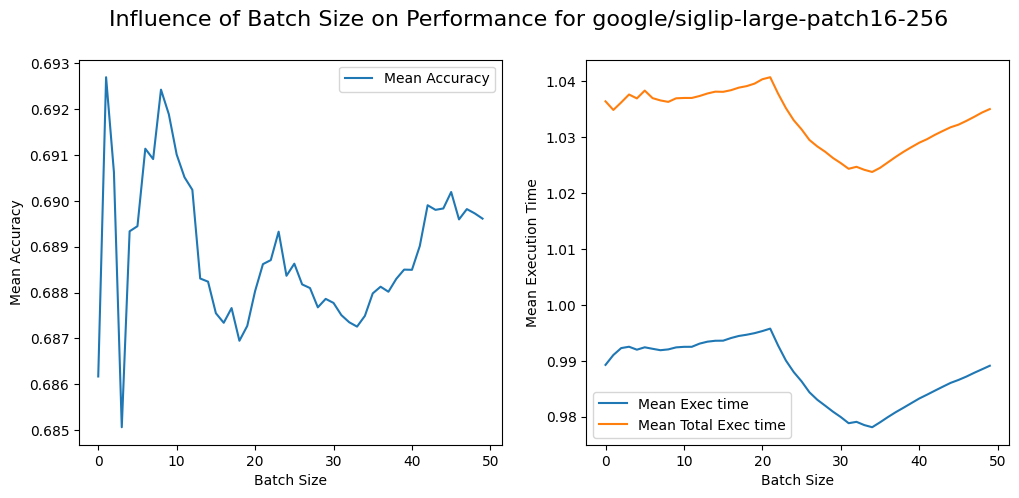

google/siglip-large-patch16-256
Accuracy difference:  1.101933290354271
Execution time difference:  1.769985828964392
Total execution time difference:  1.6271260799176142


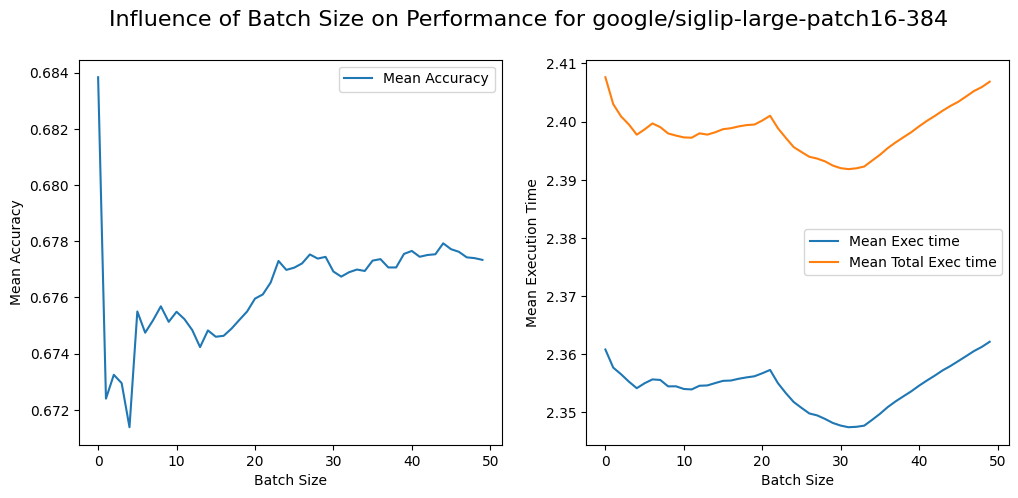

google/siglip-large-patch16-384
Accuracy difference:  1.8216972000979759
Execution time difference:  0.6219373877550004
Total execution time difference:  0.6563322078455051


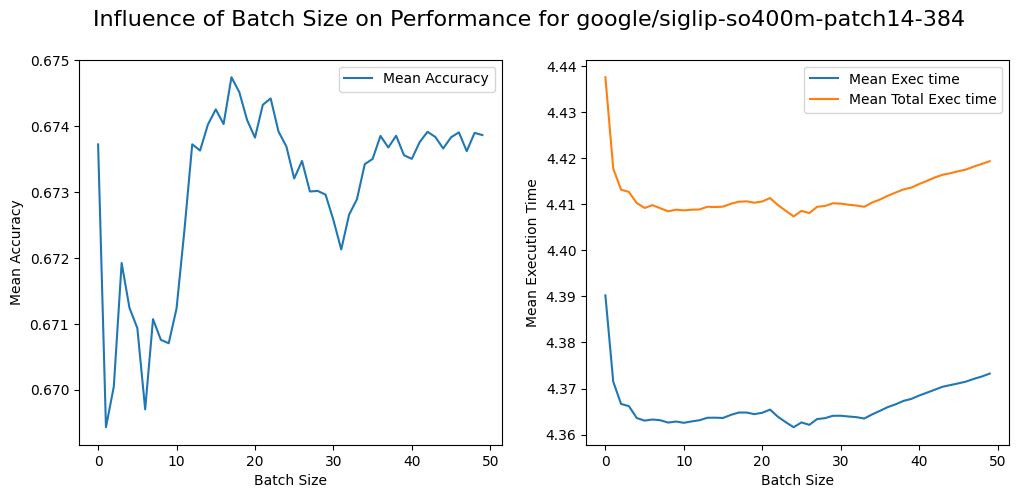

google/siglip-so400m-patch14-384
Accuracy difference:  0.7878212711742983
Execution time difference:  0.6512568846591414
Total execution time difference:  0.6804026666156977


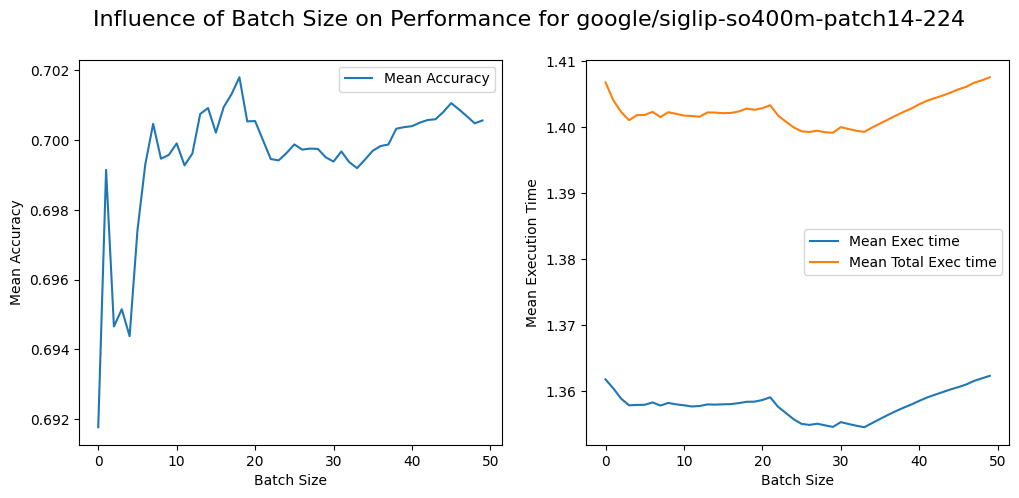

google/siglip-so400m-patch14-224
Accuracy difference:  1.4291657151095647
Execution time difference:  0.5723164429903416
Total execution time difference:  0.5985309445064927


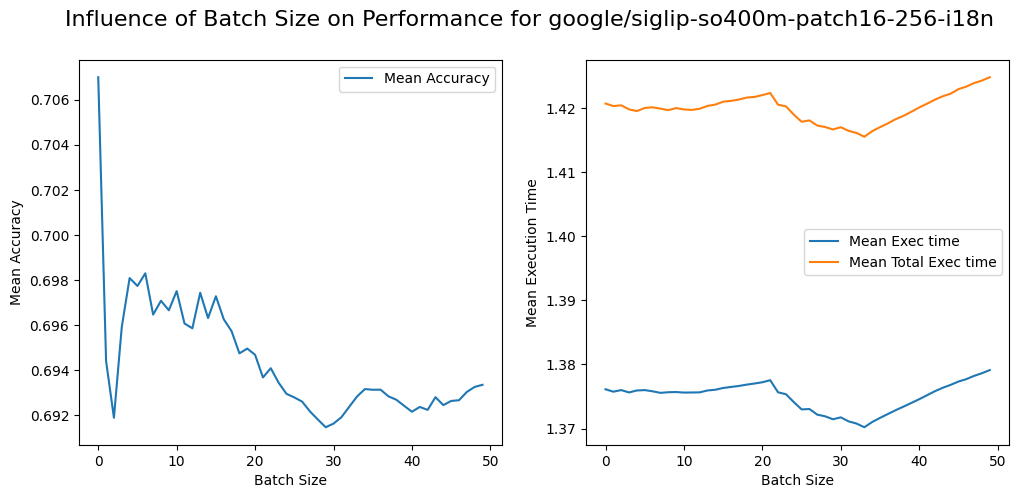

google/siglip-so400m-patch16-256-i18n
Accuracy difference:  2.1936875255199464
Execution time difference:  0.6465833816743511
Total execution time difference:  0.6519207630728415


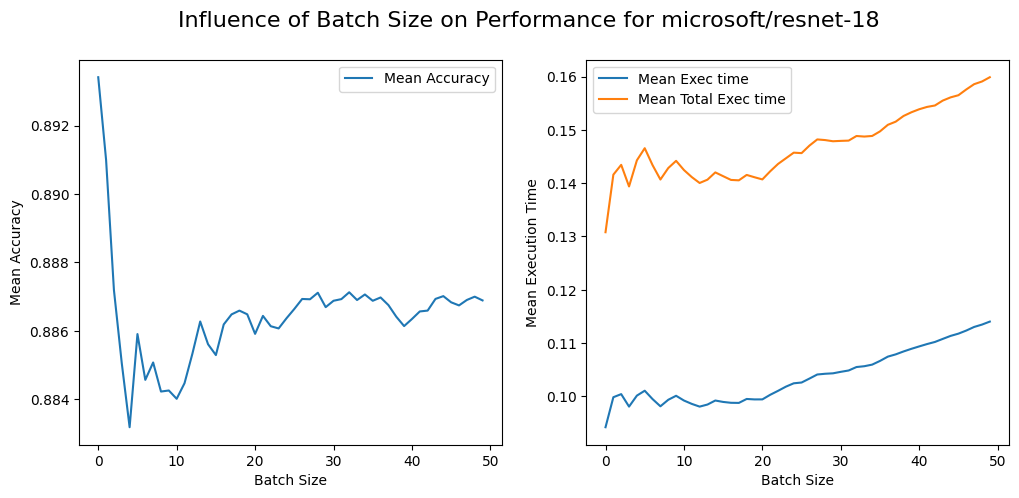

microsoft/resnet-18
Accuracy difference:  1.1458756071058995
Execution time difference:  17.383746255892575
Total execution time difference:  18.19287930973587


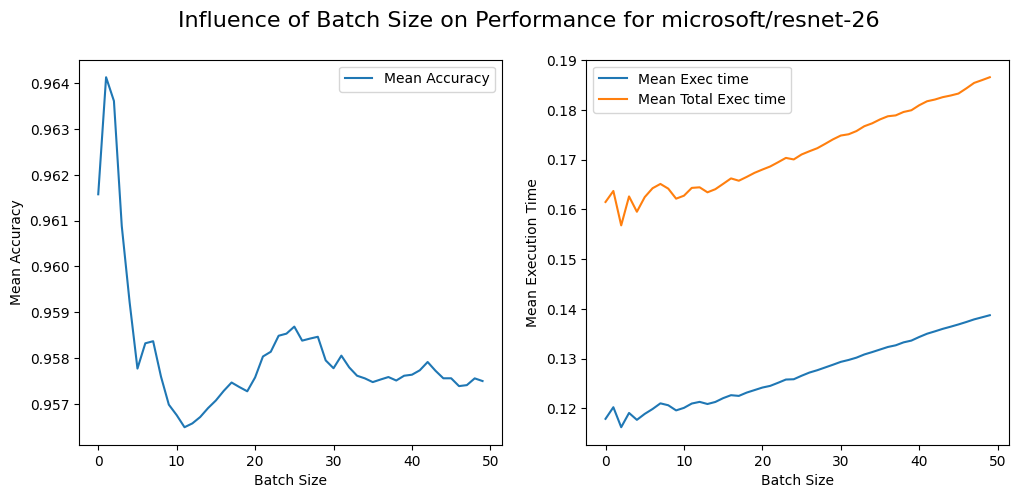

microsoft/resnet-26
Accuracy difference:  0.7925123029207748
Execution time difference:  16.21789073919558
Total execution time difference:  15.953521823967998


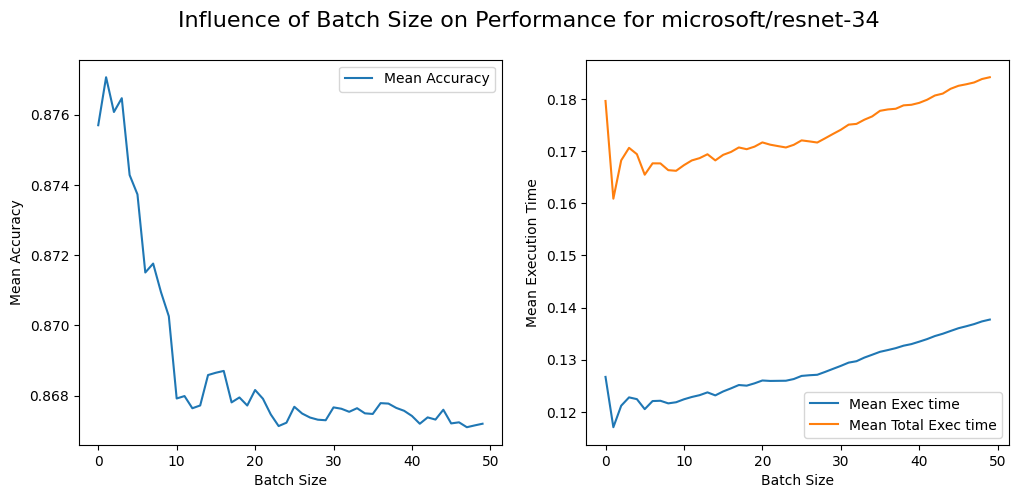

microsoft/resnet-34
Accuracy difference:  1.1354064220744207
Execution time difference:  14.997374334082576
Total execution time difference:  12.648037473247514


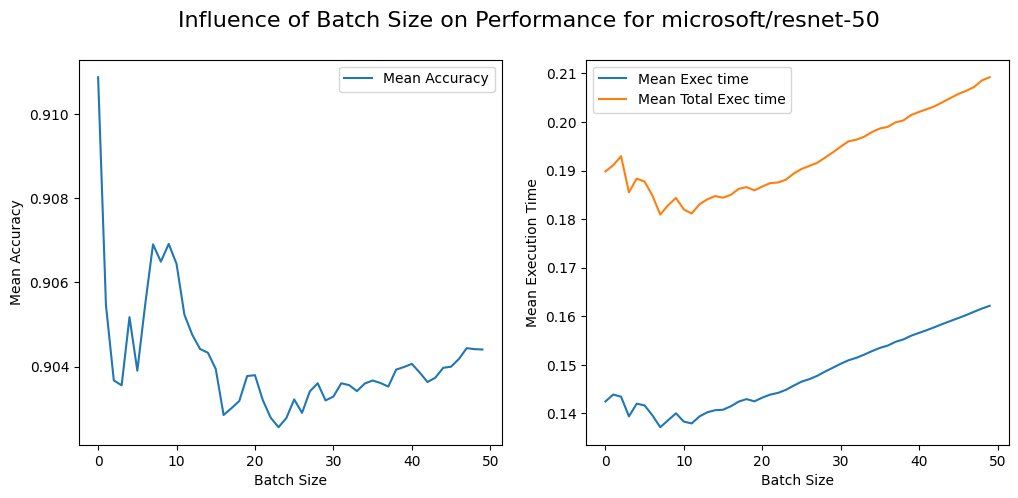

microsoft/resnet-50
Accuracy difference:  0.9124405866327598
Execution time difference:  15.422091251805279
Total execution time difference:  13.51572932173834


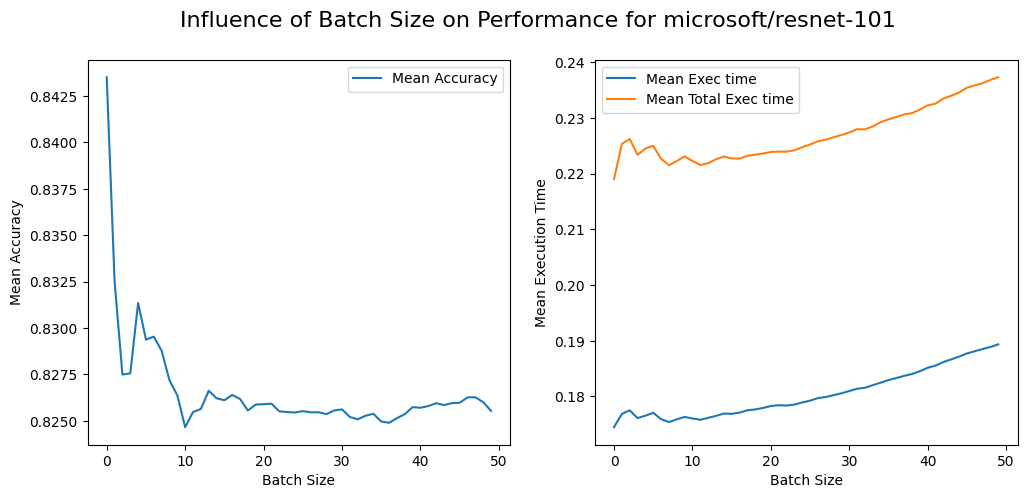

microsoft/resnet-101
Accuracy difference:  2.2353786197139103
Execution time difference:  7.856116189045722
Total execution time difference:  7.710408231935515


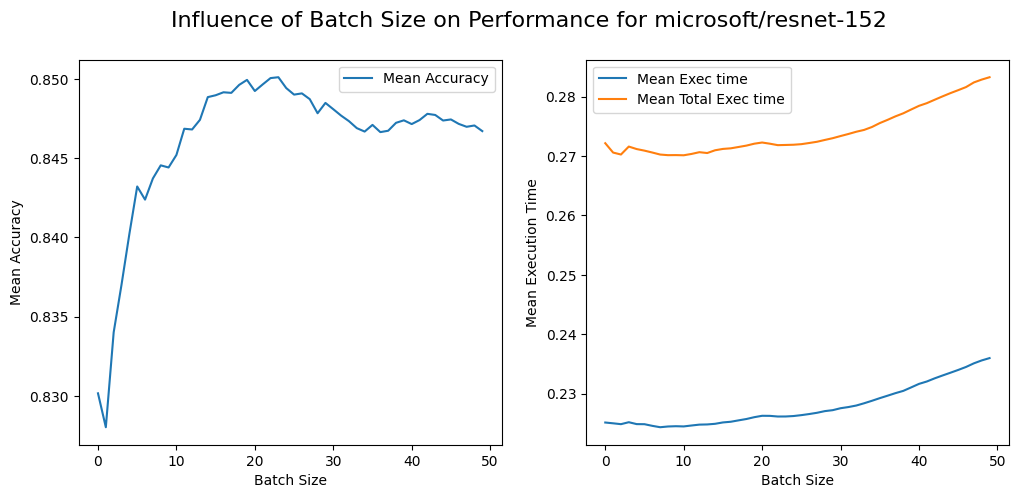

microsoft/resnet-152
Accuracy difference:  2.5953106206847707
Execution time difference:  4.928486241975681
Total execution time difference:  4.636612847363883


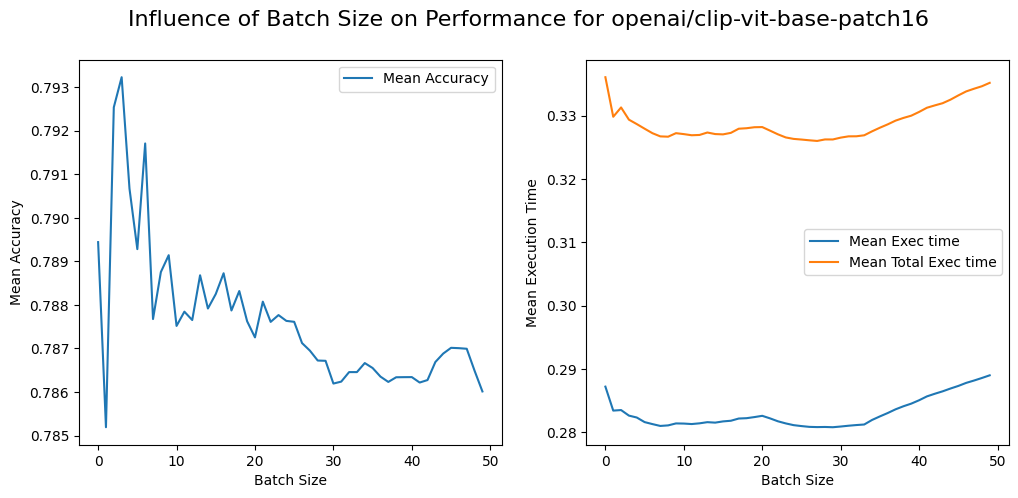

openai/clip-vit-base-patch16
Accuracy difference:  1.0127466709113473
Execution time difference:  2.83622495289099
Total execution time difference:  2.9941559364223247


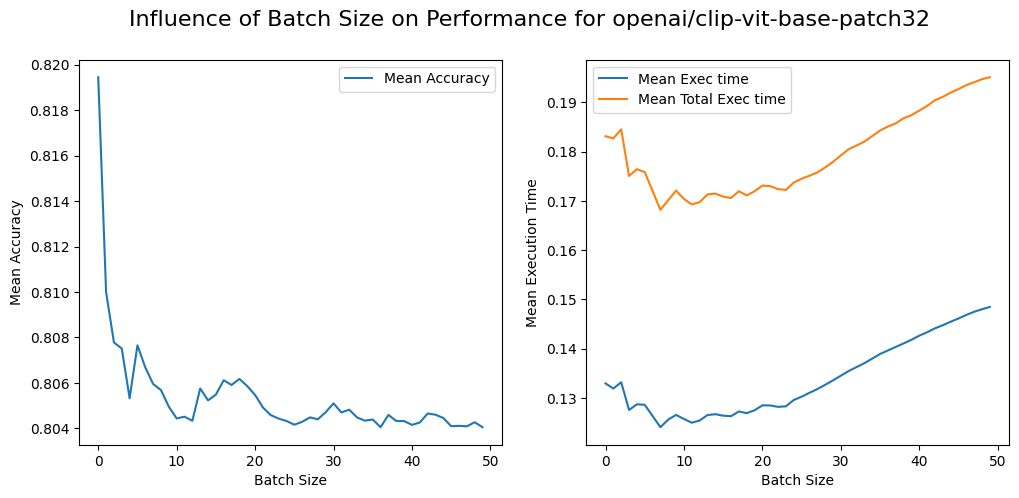

openai/clip-vit-base-patch32
Accuracy difference:  1.8788356984639236
Execution time difference:  16.453047561873248
Total execution time difference:  13.801285944426814


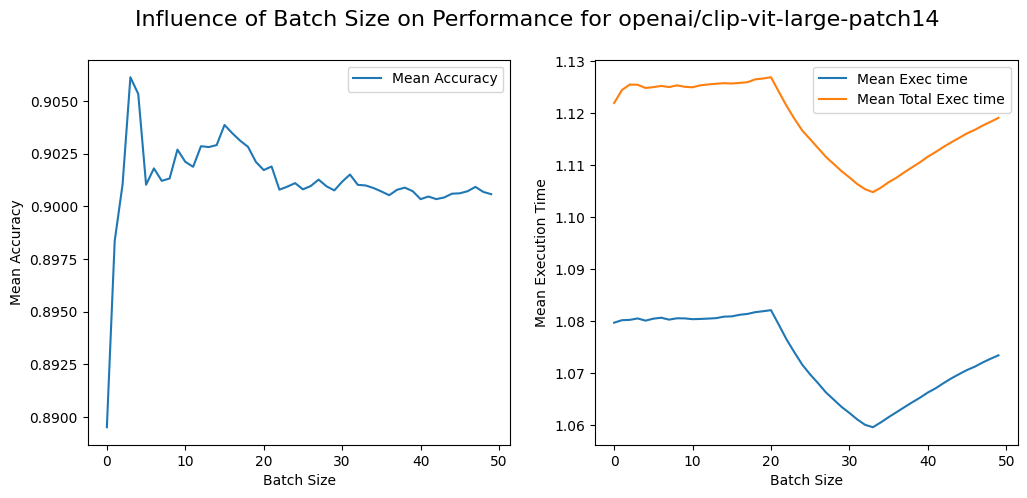

openai/clip-vit-large-patch14
Accuracy difference:  1.8336000173666003
Execution time difference:  2.0830855905459695
Total execution time difference:  1.9635503316232898


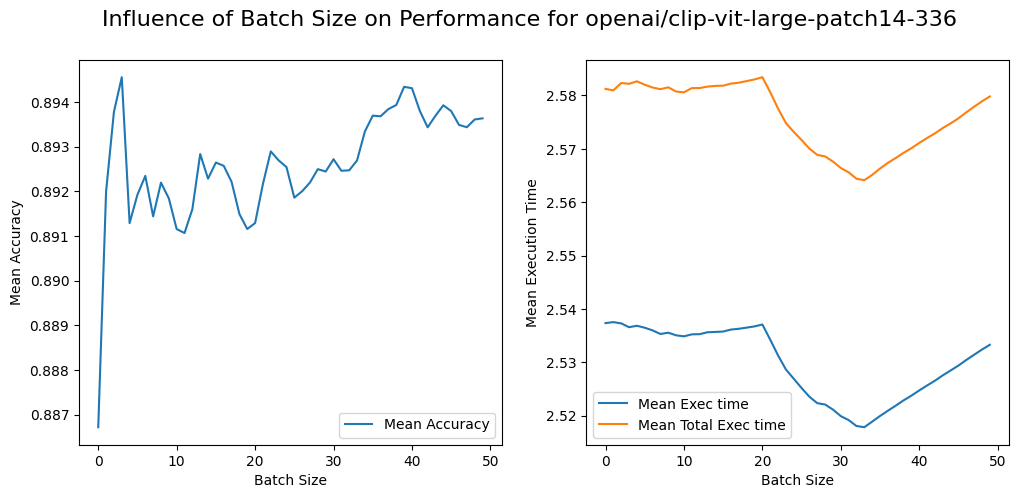

openai/clip-vit-large-patch14-336
Accuracy difference:  0.8757735727505723
Execution time difference:  0.7760652620278159
Total execution time difference:  0.7466766146740417


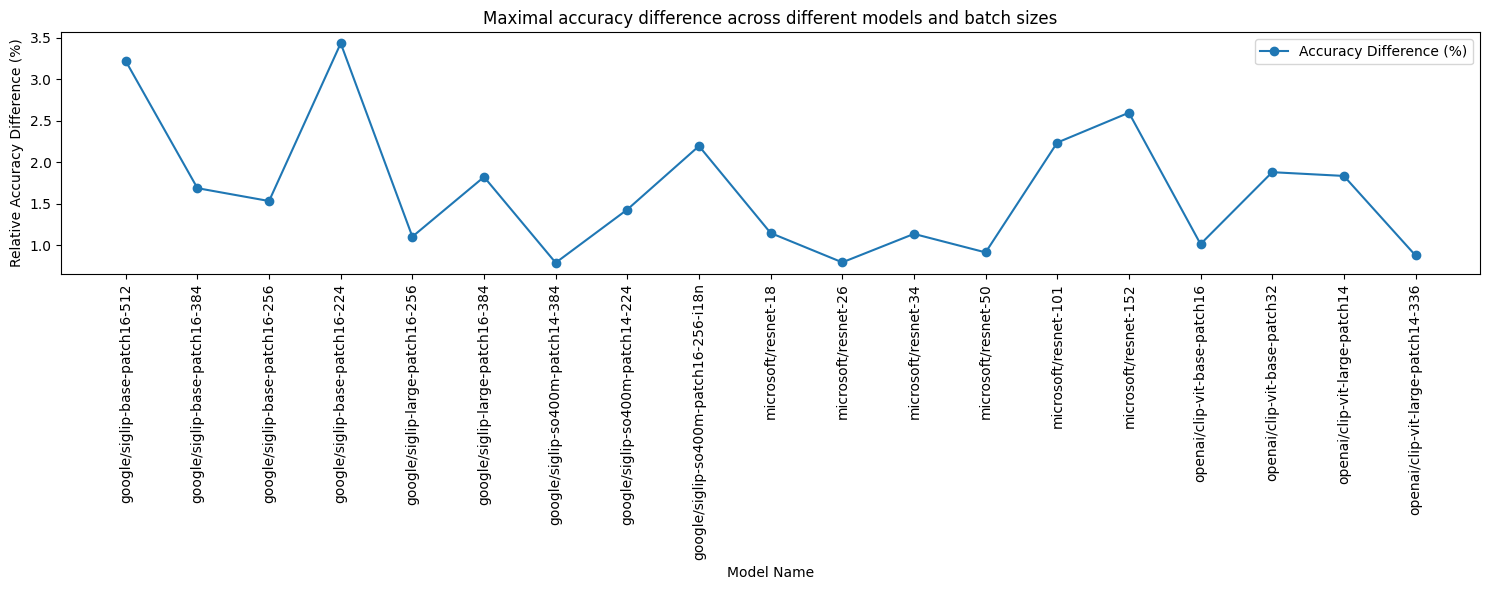

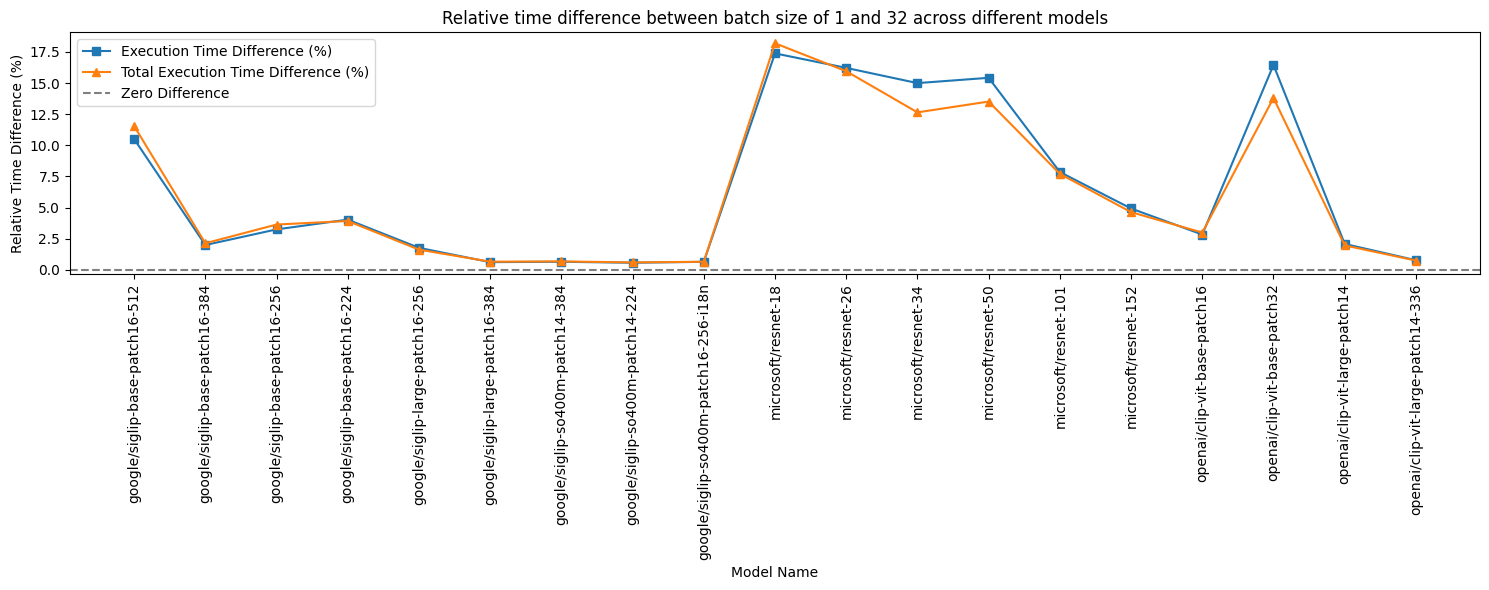

In [ ]:
all_experiments_for_all_iterations=[]
NUM_ITERATIONS = 50
NUM_ITERATIONS_ARRAY = range(NUM_ITERATIONS)
for it in NUM_ITERATIONS_ARRAY:
  all_experiments_for_all_iterations.append(load_results_from_google_drive(it, is_iteration=True))

# Settings
show_plot_for_each_exp = True
show_percentage_differences = True
show_percentage_differences_text = True

accuracy_diff_list = []
exec_time_diff_list = []
total_exec_time_diff_list = []
model_name_list = []

for i_exp in range(len(all_experiments_for_all_iterations[0])): # for experiment, every batch has the same amount of methods in it
  mean_results_list = []
  mean_exec_time_list = []
  mean_total_exec_time_list = []
  for i_batch in range(len(all_experiments_for_all_iterations)): # for iteration
    current_exp = all_experiments_for_all_iterations[i_batch][i_exp]
    mean_results_list.append(np.mean(current_exp.results_list))
    mean_exec_time_list.append(np.mean(current_exp.execution_time_list))
    mean_total_exec_time_list.append(np.mean(current_exp.total_execution_time_list))

  if show_plot_for_each_exp:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    ax1.plot(NUM_ITERATIONS_ARRAY, mean_results_list, label="Mean Accuracy")
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Mean Accuracy')
    ax1.legend()

    ax2.plot(NUM_ITERATIONS_ARRAY, mean_exec_time_list, label="Mean Exec time")
    ax2.plot(NUM_ITERATIONS_ARRAY, mean_total_exec_time_list, label="Mean Total Exec time")
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Mean Execution Time')
    ax2.legend()

    fig.suptitle("Influence of Batch Size on Performance for " + current_exp.model_path, fontsize=16)
    plt.show()

  if show_percentage_differences:
    mean_results_list = np.array(mean_results_list)
    mean_exec_time_list = np.array(mean_exec_time_list)
    mean_total_exec_time_list = np.array(mean_total_exec_time_list)

    accuracy_diff = ((np.max(mean_results_list) - np.min(mean_results_list)) / np.max(mean_results_list)) * 100
    exec_time_diff = ((np.max(mean_exec_time_list) - np.min(mean_exec_time_list)) / np.max(mean_exec_time_list)) * 100
    total_exec_time_diff = ((np.max(mean_total_exec_time_list) - np.min(mean_total_exec_time_list)) / np.max(mean_total_exec_time_list)) * 100
    # exec_time_diff = ((mean_exec_time_list[0] - mean_exec_time_list[-1]) / mean_exec_time_list[0]) * 100
    # total_exec_time_diff = ((mean_total_exec_time_list[0] - mean_total_exec_time_list[-1]) / mean_total_exec_time_list[0]) * 100

    accuracy_diff_list.append(accuracy_diff)
    exec_time_diff_list.append(exec_time_diff)
    total_exec_time_diff_list.append(total_exec_time_diff)
    model_name_list.append(current_exp.model_path)
    if show_percentage_differences_text:
      print(current_exp.model_path)
      print("Accuracy difference: ", accuracy_diff)
      print("Execution time difference: ", exec_time_diff)
      print("Total execution time difference: ", total_exec_time_diff)

if show_percentage_differences:
  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(model_name_list, accuracy_diff_list, label="Accuracy Difference (%)", marker='o')
  ax.set_xlabel("Model Name")
  ax.set_ylabel("Relative Accuracy Difference (%)")
  ax.set_title("Maximal accuracy difference across different models and batch sizes")
  ax.legend()
  plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent overlapping elements


  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(model_name_list, exec_time_diff_list, label="Execution Time Difference (%)", marker='s')
  ax.plot(model_name_list, total_exec_time_diff_list, label="Total Execution Time Difference (%)", marker='^')
  ax.axhline(y=0, color='gray', linestyle='--', label="Zero Difference") # Line at y=0
  ax.set_xlabel("Model Name")
  ax.set_ylabel("Relative Time Difference (%)")
  ax.set_title("Relative time difference between batch size of 1 and 32 across different models")
  ax.legend()
  plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent overlapping elements



# Ablation study on influence of batch size on the results

In [ ]:
# Partially repeated code...
# could most likely pack this into seperate function, keeping it like this to make sure the results are reproducible,
# don't want unexpected effect, that I didn't observe during my initial evaluation.
if DO_ABLATION_STUDY:
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

  import warnings
  warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

  for batch_size in BATCH_SIZE_ARRAY:
    for k, exp in enumerate(experiments_list):
      print("Model:", exp.model_path)
      print("Batch size:", batch_size)
      exp.init_model_n_processor()
      for i, image_path in tqdm(enumerate(jpg_files), desc='per image', total=len(jpg_files)):
          image = cv2.imread(str(image_path))
          players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[i].xyxy]
          pillow_crops = [sv.cv2_to_pillow(crop) for crop in players_crops]
          batches = chunked(pillow_crops, batch_size)

          data = []
          start_time = time.perf_counter()
          for batch in batches:
            data.append(exp.forward(batch))
          end_time = time.perf_counter()
          exp.execution_time_list.append(end_time - start_time)

          data = np.concatenate(data)
          projections = Umap_reducer.fit_transform(data)
          clusters = np.array(KMeans_model.fit_predict(projections))

          total_time = time.perf_counter()
          exp.total_execution_time_list.append(total_time - start_time)

          result, clusters = get_best_results_n_clusters(clusters.astype(bool), detections_list[i].class_id.astype(bool))
          exp.results_list.append(result.sum() / len(clusters))
          exp.clusters_list.append(clusters)
      exp.clean_up()
      experiments_list[k] = exp

      print("Mean: ", np.mean(exp.results_list))
      print("Mean execution time: ", np.mean(exp.execution_time_list))
      print("FPS: ", 1/np.mean(exp.execution_time_list))
      print(exp.results_list)
      print("\n")

    save_results_to_google_drive(experiments_list, batch_size)

In [ ]:
if DO_ABLATION_STUDY:
  all_experiments_for_all_batches=[]
  for batch_size in BATCH_SIZE_ARRAY:
    all_experiments_for_all_batches.append(load_results_from_google_drive(batch_size))

  # Settings
  show_plot_for_each_exp = True
  show_percentage_differences = True
  show_percentage_differences_text = True

  accuracy_diff_list = []
  exec_time_diff_list = []
  total_exec_time_diff_list = []
  model_name_list = []

  for i_exp in range(len(all_experiments_for_all_batches[0])): # for experiment, every batch has so many methods in it
    mean_results_list = []
    mean_exec_time_list = []
    mean_total_exec_time_list = []
    for i_batch in range(len(all_experiments_for_all_batches)): # for batch size
      current_exp = all_experiments_for_all_batches[i_batch][i_exp]
      mean_results_list.append(np.mean(current_exp.results_list))
      mean_exec_time_list.append(np.mean(current_exp.execution_time_list))
      mean_total_exec_time_list.append(np.mean(current_exp.total_execution_time_list))

    if show_plot_for_each_exp:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
      ax1.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_results_list), label="Mean Accuracy")
      ax1.set_xlabel('Batch Size')
      ax1.set_ylabel('Mean Accuracy')
      ax1.legend()

      ax2.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_exec_time_list), label="Mean Exec time")
      ax2.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_total_exec_time_list), label="Mean Total Exec time")
      ax2.set_xlabel('Batch Size')
      ax2.set_ylabel('Mean Execution Time')
      ax2.legend()

      fig.suptitle("Influence of Batch Size on Performance for " + current_exp.model_path, fontsize=16)
      plt.show()

    if show_percentage_differences:
      mean_results_list = np.array(mean_results_list)
      mean_exec_time_list = np.array(mean_exec_time_list)
      mean_total_exec_time_list = np.array(mean_total_exec_time_list)

      accuracy_diff = ((np.max(mean_results_list) - np.min(mean_results_list)) / np.max(mean_results_list)) * 100
      exec_time_diff = ((mean_exec_time_list[0] - mean_exec_time_list[-1]) / mean_exec_time_list[0]) * 100
      total_exec_time_diff = ((mean_total_exec_time_list[0] - mean_total_exec_time_list[-1]) / mean_total_exec_time_list[0]) * 100

      accuracy_diff_list.append(accuracy_diff)
      exec_time_diff_list.append(exec_time_diff)
      total_exec_time_diff_list.append(total_exec_time_diff)
      model_name_list.append(current_exp.model_path)
      if show_percentage_differences_text:
        print(current_exp.model_path)
        print("Accuracy difference: ", accuracy_diff)
        print("Execution time difference: ", exec_time_diff)
        print("Total execution time difference: ", total_exec_time_diff)

  if show_percentage_differences:
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(model_name_list, accuracy_diff_list, label="Accuracy Difference (%)", marker='o')
    ax.set_xlabel("Model Name")
    ax.set_ylabel("Relative Accuracy Difference (%)")
    ax.set_title("Maximal accuracy difference across different models and batch sizes")
    ax.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlapping elements


    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(model_name_list, exec_time_diff_list, label="Execution Time Difference (%)", marker='s')
    ax.plot(model_name_list, total_exec_time_diff_list, label="Total Execution Time Difference (%)", marker='^')
    ax.axhline(y=0, color='gray', linestyle='--', label="Zero Difference") # Line at y=0
    ax.set_xlabel("Model Name")
    ax.set_ylabel("Relative Time Difference (%)")
    ax.set_title("Relative time difference between batch size of 1 and 32 across different models")
    ax.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlapping elements
